In [1]:
import numpy as np
import xarray as xr

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Activation, MaxPool2D, SeparableConv2D, UpSampling2D,concatenate

from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.utils import plot_model
#from tensorflow import concat
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime
%matplotlib inline

In [2]:
ds_path='/scr/sci/mhayman/holodec/holodec-ml-data/'
# ds_file = 'image_data_256x256_50count.nc'
# ds_file = 'image_data_256x256_5000count.nc'
ds_file = 'image_data_64x64_5000count.nc'

ds = xr.open_dataset(ds_path+ds_file)

run_num = 0
num_epochs = 10

In [3]:
class MinMaxScalerX:
    def __init__(self,in_array,dim=None):
        """
        Create a min/max scaler object that scales
        across dims.  If dims is not provided, perform
        the scaling across all dims.
        Input is an xarray object
        """
        self.min = in_array.min(dim=dim)
        self.max = in_array.max(dim=dim)
        self.delta = self.max-self.min
        self.mid = 0.5*(self.max+self.min)
    def fit_transform(self,new_array):
        return (new_array-self.min)/self.delta
    
    def inverse_transform(self,out_array):
        return out_array*self.delta+self.min

In [4]:
ds

<xarray.Dataset>
Dimensions:   (channel: 2, hologram_number: 5000, type: 2, xsize: 64, ysize: 64)
Coordinates:
  * xsize     (xsize) int64 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63
  * ysize     (ysize) int64 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63
  * type      (type) object 'z' 'amplitude'
  * channel   (channel) object 'real' 'imag'
Dimensions without coordinates: hologram_number
Data variables:
    image     (hologram_number, xsize, ysize) float64 ...
    labels    (hologram_number, xsize, ysize, type) float64 ...
    image_ft  (hologram_number, xsize, ysize, channel) float64 ...
Attributes:
    xdim:         64
    pixel_width:  3e-06
    wavelength:   3.55e-07
    zmax:         0
    zmin:         -0.001
    z_invalid:    0
    rspot:        1e-05

In [5]:
split_index = np.int(0.7*ds.sizes['hologram_number'])  # number of training+validation points
valid_index = np.int(0.2*ds.sizes['hologram_number'])  # number of validation points
all_labels = ds['labels']

train_labels = all_labels.isel(hologram_number=slice(valid_index,split_index))
test_labels = all_labels.isel(hologram_number=slice(split_index,None))
val_labels = all_labels.isel(hologram_number=slice(None,valid_index))

scaler = MinMaxScalerX(train_labels,dim=('hologram_number','type'))
scaled_train_labels = scaler.fit_transform(train_labels)
scaled_val_labels = scaler.fit_transform(val_labels)
scaled_test_labels = scaler.fit_transform(test_labels)
scaled_all_labels = scaler.fit_transform(all_labels)

In [6]:
in_data = ds['image_ft']

In [7]:
valid_index

1000

In [8]:
if not 'channel' in in_data.dims:
    in_data = in_data.expand_dims("channel", 3)

In [9]:
scaled_in_data = in_data/2

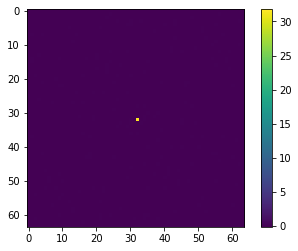

In [10]:
plt.figure()
plt.imshow(scaled_in_data.values[210,:,:,0])
plt.colorbar()

In [11]:
nn_descript = 'Lossless_UNET'
cnn_input = Input(shape=scaled_in_data.shape[1:])  # input

conv_1a = SeparableConv2D(4, (5, 5), padding="same")(cnn_input)
act_1a = Activation("relu")(conv_1a)
conv_1b = SeparableConv2D(4, (5, 5), padding="same")(act_1a)
act_1b = Activation("relu")(conv_1b)
pool_1 = MaxPool2D(pool_size=(4, 4))(act_1b)

conv_2a = SeparableConv2D(16,(5,5),padding="same")(pool_1)
act_2a = Activation("relu")(conv_2a)
conv_2b = SeparableConv2D(16,(5,5),padding="same")(act_2a)
act_2b = Activation("relu")(conv_2b)
pool_2 = MaxPool2D(pool_size=(4, 4))(act_2b)

conv_3a = SeparableConv2D(256,(5,5),padding="same")(pool_2)
act_3a = Activation("relu")(conv_3a)
conv_3b = SeparableConv2D(256,(5,5),padding="same")(act_3a)
act_3b = Activation("relu")(conv_3b)
pool_3 = MaxPool2D(pool_size=(4, 4))(act_3b)

conv_4a = SeparableConv2D(4096,(5,5),padding="same")(pool_3)
act_4a = Activation("relu")(conv_4a)

conv_4b = SeparableConv2D(4096,(5,5),padding="same")(act_4a)
act_4b = Activation("relu")(conv_4b)

upsamp_5 = UpSampling2D((4,4))(act_4b)
concat_5 = concatenate([upsamp_5,act_3b],axis=3)
conv_5a = SeparableConv2D(256,(5,5),padding="same")(concat_5)
act_5a = Activation("relu")(conv_5a)
conv_5b = SeparableConv2D(256,(5,5),padding="same")(act_5a)
act_5b = Activation("relu")(conv_5b)


upsamp_6 = UpSampling2D((4,4))(act_5b)
concat_6 = concatenate([upsamp_6,act_2b],axis=3)
conv_6a = SeparableConv2D(16,(5,5),padding="same")(concat_6)
act_6a = Activation("relu")(conv_6a)
conv_6b = SeparableConv2D(16,(5,5),padding="same")(act_6a)
act_6b = Activation("relu")(conv_6b)

upsamp_7 = UpSampling2D((4,4))(act_6b)
concat_7 = concatenate([upsamp_7,act_1b],axis=3)
conv_7 = SeparableConv2D(8,(5,5),padding="same")(concat_7)
act_7 = Activation("relu")(conv_7)

conv_8 = SeparableConv2D(8,(5,5),padding="same")(act_7)
act_8 = Activation("relu")(conv_8)

out = SeparableConv2D(2,(1,1),padding="same")(act_8)


mod = Model(cnn_input, out)
mod.compile(optimizer="adam", loss="mae",metrics=['acc'])
mod.summary()
run_num=0

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 2)]  0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 64, 64, 4)    62          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 4)    0           separable_conv2d[0][0]           
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 64, 64, 4)    120         activation[0][0]                 
______________________________________________________________________________________________

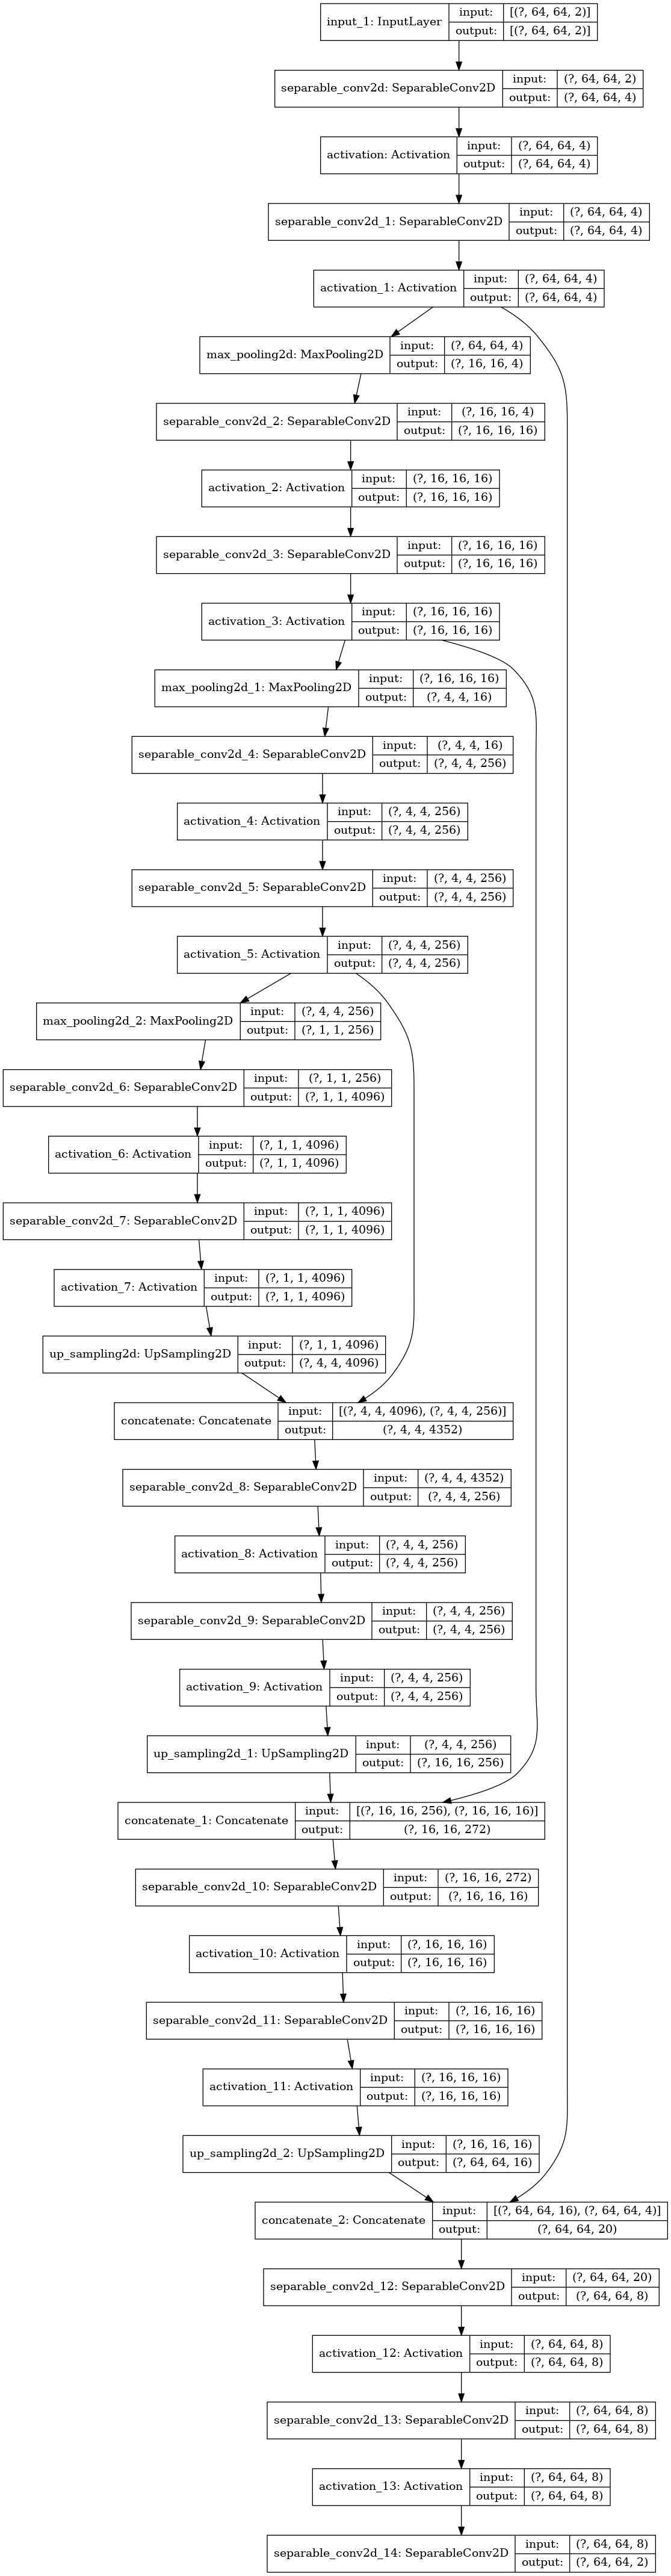

In [12]:
plot_model(mod,show_shapes=True,to_file="results/holodec_"+nn_descript+'_'+ds_file.replace(".nc","")+".png")

In [13]:
history = mod.fit(scaled_in_data[valid_index:split_index].values,
                  scaled_train_labels.values, 
                  batch_size=16, epochs=num_epochs, verbose=1,
                  validation_data=(scaled_in_data[:valid_index].values,scaled_val_labels.values))
run_num+=1

Train on 2500 samples, validate on 1000 samples
Epoch 1/10
2500/2500 [==============================] - 94s 38ms/sample - loss: 0.0027 - acc: 0.4914 - val_loss: 0.0027 - val_acc: 0.9900
Epoch 2/10
2500/2500 [==============================] - 91s 36ms/sample - loss: 0.0027 - acc: 0.5013 - val_loss: 0.0027 - val_acc: 0.9899
Epoch 3/10
2500/2500 [==============================] - 89s 35ms/sample - loss: 0.0027 - acc: 0.5015 - val_loss: 0.0027 - val_acc: 0.0125
Epoch 4/10
2500/2500 [==============================] - 87s 35ms/sample - loss: 0.0027 - acc: 0.5000 - val_loss: 0.0027 - val_acc: 0.0104
Epoch 5/10
2500/2500 [==============================] - 86s 35ms/sample - loss: 0.0027 - acc: 0.4999 - val_loss: 0.0027 - val_acc: 0.9900
Epoch 6/10
2500/2500 [==============================] - 86s 34ms/sample - loss: 0.0027 - acc: 0.5015 - val_loss: 0.0027 - val_acc: 0.9899
Epoch 7/10
2500/2500 [==============================] - 85s 34ms/sample - loss: 0.0027 - acc: 0.5017 - val_loss: 0.0027 - va

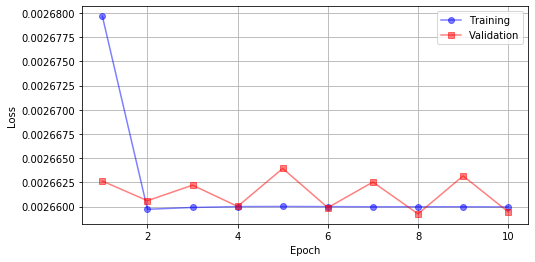

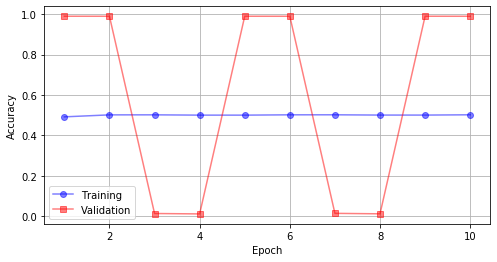

In [14]:
epochs = np.arange(len(history.history['loss']))+1
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(epochs,history.history['loss'],'bo-',alpha=0.5,label='Training')
ax.plot(epochs,history.history['val_loss'],'rs-',alpha=0.5,label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(b=True)
plt.legend()
plt.savefig("results/LossHistory_"+nn_descript+'_'+ds_file.replace(".nc","")+f"_{num_epochs}epochs_run{run_num}"+".png", dpi=200, bbox_inches="tight")

fig, bx = plt.subplots(1, 1, figsize=(8, 4))
bx.plot(epochs,history.history['acc'],'bo-',alpha=0.5,label='Training')
bx.plot(epochs,history.history['val_acc'],'rs-',alpha=0.5,label='Validation')
bx.set_xlabel('Epoch')
bx.set_ylabel('Accuracy')
bx.grid(b=True)
plt.legend()
plt.savefig("results/AccuracyHistory_"+nn_descript+'_'+ds_file.replace(".nc","")+f"_{num_epochs}epochs_run{run_num}"+".png", dpi=200, bbox_inches="tight")


In [15]:
save_model(mod, ds_path+"/models/holodec_"+nn_descript+'_'+ds_file.replace(".nc","")+f"{num_epochs}epochs_run{run_num}"+".h5", save_format="h5")

In [16]:
# can skip the training process and just load the CNN model
# mod = load_model(ds_path+"/models/holodec_UNET_image_data_256x256_5000count30epochs_run1.h5")

In [17]:
cnn_start = datetime.datetime.now()
preds_out = mod.predict(scaled_in_data.values, batch_size=64)
cnn_stop = datetime.datetime.now()
print(f"{scaled_in_data.values.shape[0]} samples in {(cnn_stop-cnn_start).total_seconds()} seconds")
print(f"for {(cnn_stop-cnn_start).total_seconds()/scaled_in_data.values.shape[0]} seconds per hologram")

5000 samples in 16.809428 seconds
for 0.0033618856 seconds per hologram


In [18]:
preds_out.shape

(5000, 64, 64, 2)

In [19]:
preds_out_da = xr.DataArray(preds_out,dims=('hologram_number','xsize','ysize','type'),
                            coords=all_labels.coords)

In [20]:
preds_original = scaler.inverse_transform(preds_out_da)

In [21]:
mean_error = (preds_original[split_index:] - test_labels).mean(dim=('hologram_number','xsize','ysize'))
std_error = (preds_original[split_index:] - test_labels).std(dim=('hologram_number','xsize','ysize'))

In [ ]:
validation_data = {}
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for a, clabel in enumerate(all_labels.coords['type'].values):
    ax=axes.ravel()[a]
    ax.scatter(test_labels.sel(channel=clabel).values.flatten(), preds_original.sel(channel=clabel,hologram_number=slice(split_index,None)).values.flatten(), 1, 'k')
    diag = np.linspace(test_labels.sel(channel=clabel).min(), test_labels.sel(channel=clabel).max(), 10)
    ax.plot(diag, diag, 'b--' )
    ax.set_title(clabel)
    plt.text(0.1,0.9,f"${mean_error.sel(channel=clabel).values:.1f} \pm {std_error.sel(channel=clabel).values:.1f} \mu m$",ha='left',va='top',transform=ax.transAxes)
#     validation_data[test_labels.columns[a]] = test_labels.iloc[:, a]
#     validation_data[test_labels.columns[a]+'_pred'] = preds_original[split_index:, a]
plt.savefig("results/error_scatter_"+nn_descript+'_'+ds_file.replace(".nc","")+f"{num_epochs}epochs_run{run_num}"+".png", dpi=200, bbox_inches="tight")
# validation_data_df = pd.DataFrame(validation_data)

In [ ]:
mean_error

In [ ]:
std_error

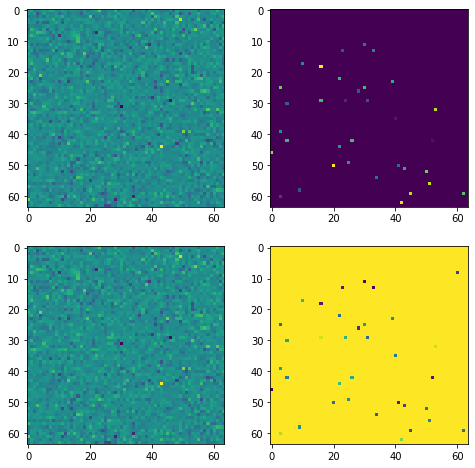

In [22]:
ind=100
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.ravel()
ax[0].imshow(preds_original.sel(type='amplitude',hologram_number=ind).values)
ax[1].imshow(all_labels.sel(type='amplitude',hologram_number=ind).values)
ax[2].imshow(preds_original.sel(type='z',hologram_number=ind).values)
ax[3].imshow(all_labels.sel(type='z',hologram_number=ind).values,vmin=-1e-3,vmax=0)

In [ ]:
preds_original.sel(channel='amplitude',hologram_number=ind).values

In [ ]:
test_labels.sel(channel='z').max()

In [ ]:
all_labels.coords['channel'].values

In [ ]:
test_z = test_labels.sel(type='z').values.flatten()
pred_z = preds_original.sel(type='z',hologram_number=slice(split_index,None)).values.flatten()

In [ ]:
test_a = test_labels.sel(type='amplitude').values.flatten()
pred_a = preds_original.sel(type='amplitude',hologram_number=slice(split_index,None)).values.flatten()

In [ ]:
idel = np.nonzero(test_a==1)[0]
test_z = np.delete(test_z,idel)
pred_z = np.delete(pred_z,idel)

In [ ]:
test_a = np.delete(test_a,idel)
pred_a = np.delete(pred_a,idel)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(test_z, pred_z, 1, 'k')
axes[1].scatter(test_a, pred_a, 1, 'k')

In [ ]:


fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(test_a, pred_a, 1, 'k')

In [ ]:
preds_original.sel(channel='amplitude',hologram_number=ind).values.min()